<a href="https://colab.research.google.com/github/amirazaiz/Cycle_GAN/blob/main/0_1CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [ ]:
import numpy as np
import cv2
import keras
import matplotlib.pyplot as plt

In [ ]:
from random import random
from numpy import load, zeros, ones, asarray
from numpy.random import randint

In [ ]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Conv2D,Input,Conv2DTranspose,Concatenate,LeakyReLU,Activation

In [ ]:
from instancenormalization import InstanceNormalization

# Discriminator architecture

In [ ]:
# 70 X 70 PatchGAN
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])

	return model

# Resnet block that i'm gonna be using as part of the generator

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# Generator Architecture

c7s1-64,d128,d256, R256 * 9, u128,u64, c7s1-3

In [ ]:
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# GAN Architecture

In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time.
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False

	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

    # define the optimizer
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'],
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# Helper functions

In [ ]:
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def save_models(step, g_model_AtoB, g_model_BtoA):
  filename1 = '/content/drive/MyDrive/0-myComputerVisionProjects/saved_cycle_gan/g_model_AtoB_%06.h5'
  g_model_AtoB.save(filename1)

  filename2 = '/content/drive/MyDrive/0-myComputerVisionProjects/saved_cycle_gan/g_model_BtoA_%06.h5'
  g_model_BtoA.save(filename2)

In [ ]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):

  X_in, _ = generate_real_samples(trainX, n_samples, 0)
  X_out, _ = generate_fake_samples(g_model, X_in, 0)

  X_in = (X_in + 1) / 2.0
  X_out = (X_out + 1) / 2.0

  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshoow(X_in[i])

  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i + n_samples)
    plt.axis('off')
    plt.imshoow(X_out[i])

  filename1 = '/content/drive/MyDrive/0-myComputerVisionProjects/saved_cycle_gan/%s_generated_plot_%06d.png' % (name, (step+1))
  plt.savefig(filename1)
  plt.close()

In [ ]:
# provide the last generated 50 images as input to the discriminator

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# Train Function

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs

	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)

		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        #In one epoch you'd have iterations equal to the number of images.
        #If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
        # If batch size (total images)=100, performance will be summarized after every 75th iteration.
		# if (i+1) % (bat_per_epo * 1) == 0:
		# 	# plot A->B translation
		# 	summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
		# 	# plot B->A translation
		# 	summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		# if (i+1) % (bat_per_epo * 5) == 0:
		# 	# save the models
    #         # #If batch size (total images)=100, model will be saved after
    #         #every 75th iteration x 5 = 375 iterations.
		# 	save_models(i, g_model_AtoB, g_model_BtoA)

# Loading & preprrocessing the data

In [ ]:
import os
from os import listdir
from numpy import asarray,load,vstack,savez_compressed
from tensorflow.keras.utils import img_to_array,load_img

In [ ]:
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [ ]:
path = "/content/drive/MyDrive/0-myComputerVisionProjects/0-1-vangogh2image_dataset/vangogh2photo/"

In [ ]:
dataA_all = load_images(path + 'trainA/')
print(dataA_all.shape)

dataB_all = load_images(path + 'trainB/')
print(dataB_all.shape)

(400, 256, 256, 3)
(2241, 256, 256, 3)


In [ ]:
from sklearn.utils import resample

dataA = resample(dataA_all, replace =False, n_samples=400, random_state=42)
dataB = resample(dataB_all, replace =False, n_samples=400, random_state=42)

In [ ]:
print(dataA.shape)
print(dataB.shape)

(400, 256, 256, 3)
(400, 256, 256, 3)


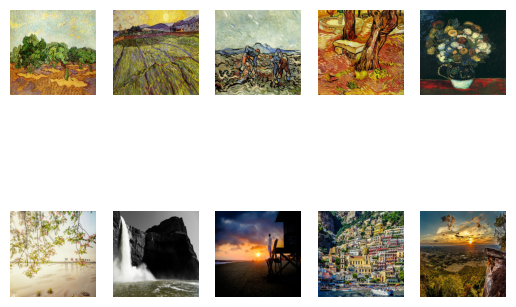

In [ ]:
n_samples = 5

for i in range(n_samples):
  plt.subplot(2, n_samples, 1+i)
  plt.axis('off')
  plt.imshow(dataA[i].astype('uint8'))

for i in range(n_samples):
  plt.subplot(2, n_samples, 1+i+ n_samples)
  plt.axis('off')
  plt.imshow(dataB[i].astype('uint8'))

In [ ]:
data = [dataA, dataB]
print(data[0].shape, data[1].shape)

(400, 256, 256, 3) (400, 256, 256, 3)


In [ ]:
def preprocess_data(data):
  X1 ,X2 = data[0], data[1]
  X1 = ( X1 - 127.5)/127.5
  X2 = ( X2 - 127.5)/127.5
  return [X1, X2]

In [ ]:
dataset = preprocess_data(data)

In [ ]:
dataset[0].shape[1:]

(256, 256, 3)

In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
g_model_BtoA.summary()

# Training

In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs = 10)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
Iteration>2334, dA[0.180,0.116] dB[0.181,0.028] g[5.383,5.507]
1/1 [==============================] - 0s 24ms/step
Iteration>2335, dA[0.057,0.100] dB[0.008,0.023] g[7.980,7.549]
1/1 [==============================] - 0s 60ms/step
Iteration>2336, dA[0.023,0.207] dB[0.025,0.016] g[7.720,6.993]
1/1 [==============================] - 0s 25ms/step
Iteration>2337, dA[0.114,0.084] dB[0.030,0.250] g[5.261,5.208]
1/1 [==============================] - 0s 28ms/step
Iteration>2338, dA[0.021,0.019] dB[0.118,0.058] g[4.587,5.312]
1/1 [==============================] - 0s 22ms/step
Iteration>2339, dA[0.060,0.089] dB[0.052,0.008] g[7.600,7.112]
1/1 [==============================] - 0s 23ms/step
Iteration>2340, dA[0.029,0.010] dB[0.011,0.045] g[7.099,6.932]
1/1 [==============================] - 0s 32ms/step
Iteration>2341, dA[0.145,0.015] dB[0.075,0.006] g[6.913,6.582]
1/1 [========================

In [ ]:
g_model_AtoB.save('/content/drive/MyDrive/0-myComputerVisionProjects/10epochs_AtoB.h5')
g_model_BtoA.save('/content/drive/MyDrive/0-myComputerVisionProjects/10epochs_BtoA.h5')

# Plotting the results

In [ ]:
def show_plot(imagesX, imageY1, imagesY2):
  images = np.vstack((imagesX, imageY1, imagesY2))
  titles = ['Real', 'Generated', 'Reconstructed']
  images = (images + 1 ) / 2.0

  for i in range(len(images)):
    plt.subplot(1, len(images), 1 + i)
    plt.axis('off')
    plt.imshow(images[i])
    # plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])

  plt.show()

In [ ]:
def select_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  return X

In [ ]:
A_data = resample(
    dataA_all,
    replace = False,
    n_samples = 50,
    random_state = 42
)
B_data = resample(
    dataB_all,
    replace = False,
    n_samples = 50,
    random_state = 42
)

In [ ]:
A_data = (A_data - 127.5) / (127.5)
B_data = (B_data - 127.5) / (127.5)

1/1 [==============================] - 0s 23ms/step


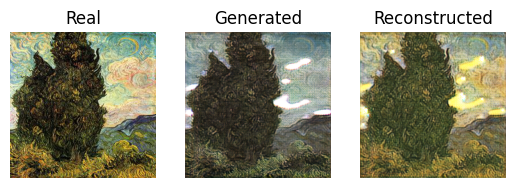

In [ ]:
A_real = select_samples(A_data, 1)
B_generated  = g_model_AtoB.predict(A_real)
A_reconstructed = g_model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

1/1 [==============================] - 0s 26ms/step


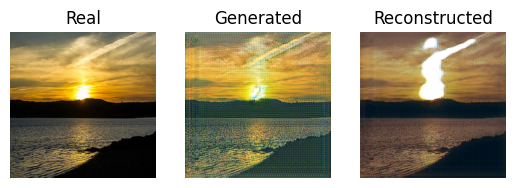

In [ ]:
# plot B->A->B (Photo to VanGogh to Photo)
B_real = select_samples(B_data, 1)
A_generated  = g_model_BtoA.predict(B_real)
B_reconstructed = g_model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

# Testing On new images

In [ ]:
def preprocess_input_image(path):
  img = cv2.imread(path,1)
  img = cv2.resize(img, (256,256))
  img = (img.astype('float32')/ 127.5) - 1.0
  img = np.expand_dims(img, axis=0)
  # img = img_to_array(img)
  return img

In [ ]:
image1 = preprocess_input_image('p1.jpg')
image2 = preprocess_input_image('p2.jpg')
image3 = preprocess_input_image('p3.jpg')
# image4 = preprocess_input_image('p4.jpg')

In [ ]:
test_images = [image1, image2, image3]
test_images = np.array(test_images)

In [ ]:
from instancenormalization import InstanceNormalization

In [ ]:
import tensorflow
from tensorflow.keras.models import load_model

In [ ]:
with tensorflow.keras.utils.custom_object_scope({'InstanceNormalization': InstanceNormalization}):
    # Load the model
    model_AtoB = load_model('/content/drive/MyDrive/0-myComputerVisionProjects/10epochs_AtoB.h5')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
with tensorflow.keras.utils.custom_object_scope({'InstanceNormalization': InstanceNormalization}):
    # Load the model
    model_BtoA = load_model('/content/drive/MyDrive/0-myComputerVisionProjects/10epochs_BtoA.h5')

In [ ]:
for image in test_images:
  van_gogh_generated = model_BtoA.predict(image)
  image_reconstructed = model_AtoB.predict(van_gogh_generated)
  show_plot(image, van_gogh_generated, image_reconstructed)